In this notebook, we use a **simple momentum strategy** with equal **weight** for simplicity to test the hypothesis: The stocks that have high returns will continue to have high returns, while stocks that have low returns will continue to have low returns

In [11]:
import pandas as pd
import numpy as np
import  matplotlib.pyplot as plt

In [3]:
# Read Data
file_path = r"C:\Users\ADMIN\Documents\CF_LeHoangPhuc-22110160_TranLongNhat-22110142\lab01\top_1000_stock_2015_2025.csv"
df = pd.read_csv(file_path, parse_dates=["date"])

# Kiểm tra cấu trúc dữ liệu 
print(df.head())
print(df.columns)

        date ticker       open       high        low      close  adj_close  \
0 2015-01-02   AAPL  27.847500  27.860001  26.837500  27.332500  24.261047   
1 2015-01-02   ABBV  65.440002  66.400002  65.440002  65.889999  42.091419   
2 2015-01-02    ABT  45.250000  45.450001  44.639999  44.900002  36.418671   
3 2015-01-02   ADBE  72.699997  73.199997  71.889999  72.339996  72.339996   
4 2015-01-02    ADI  55.680000  56.250000  54.970001  55.540001  44.511143   

        volume  
0  212818400.0  
1    5086100.0  
2    3216600.0  
3    2349200.0  
4    1323200.0  
Index(['date', 'ticker', 'open', 'high', 'low', 'close', 'adj_close',
       'volume'],
      dtype='object')


In [4]:
# resample to month-end prices 
df = df.set_index("date")

agg_dict = {
    "open": "first",
    "high": "max",
    "low": "min",
    "close": "last",
    "adj_close": "last",
    "volume": "sum"
}

monthly = (
    df.groupby("ticker")
      .resample("M")
      .agg(agg_dict)
      .reset_index()
)
print(monthly.head())

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16124\2414465770.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")


  ticker       date       open       high        low      close  adj_close  \
0      A 2015-01-31  41.180000  41.310001  37.680000  37.770000  34.567509   
1      A 2015-02-28  37.900002  42.490002  37.709999  42.209999  38.631046   
2      A 2015-03-31  42.340000  42.740002  40.369999  41.549999  38.120682   
3      A 2015-04-30  41.459999  43.590000  40.720001  41.369999  37.955536   
4      A 2015-05-31  41.410000  42.930000  40.820000  41.189999  37.790375   

       volume  
0  53086600.0  
1  52418300.0  
2  44856400.0  
3  47256700.0  
4  44096800.0  


In [5]:
# Caculate monthly log-return
monthly["log_return"] = (
    np.log(monthly["adj_close"]) - 
    np.log(monthly.groupby("ticker")["adj_close"].shift(1))
)

monthly = monthly.dropna(subset=["log_return"])
monthly["lagged_return"] = monthly.groupby("ticker")["log_return"].shift(1)

print(monthly.head())


  ticker       date       open       high        low      close  adj_close  \
1      A 2015-02-28  37.900002  42.490002  37.709999  42.209999  38.631046   
2      A 2015-03-31  42.340000  42.740002  40.369999  41.549999  38.120682   
3      A 2015-04-30  41.459999  43.590000  40.720001  41.369999  37.955536   
4      A 2015-05-31  41.410000  42.930000  40.820000  41.189999  37.790375   
5      A 2015-06-30  41.430000  41.430000  38.480000  38.580002  35.484417   

       volume  log_return  lagged_return  
1  52418300.0    0.111142            NaN  
2  44856400.0   -0.013299       0.111142  
3  47256700.0   -0.004342      -0.013299  
4  44096800.0   -0.004361      -0.004342  
5  58978100.0   -0.062961      -0.004361  


In [6]:
# Simple Momentum Strategy

n = 150  # choose how many stocks to long/short

monthly["rank"] = monthly.groupby("date")["lagged_return"].rank(method="first", ascending=False)
monthly["position"] = 0
monthly.loc[monthly["rank"] <= n, "position"] = 1
monthly.loc[monthly["rank"] > monthly.groupby("date")["rank"].transform("max") - n, "position"] = -1

# Caculate monthly weight return
monthly["weight"] = monthly.groupby(["date", "position"])["position"].transform(
    lambda x: 1 / len(x) if x.iloc[0] != 0 else 0
)
monthly["weighted_return"] = monthly["log_return"] * monthly["weight"]



In [7]:
# Compute average return per side each month
avg_returns = (
    monthly[monthly["position"] != 0]
    .groupby(["date", "position"])["log_return"]
    .mean()
    .unstack(fill_value=0)
)

# Compute long–short portfolio return
avg_returns["portfolio_return"] = (avg_returns[1] - avg_returns[-1]) / 2

#Cumulative performance
avg_returns["cum_return"] = np.exp(avg_returns["portfolio_return"].cumsum())


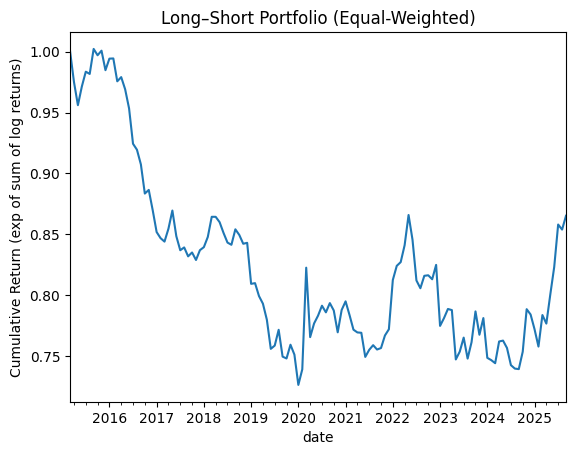

In [8]:
# Plot Result
avg_returns["cum_return"].plot(title="Long–Short Portfolio (Equal-Weighted)")
plt.ylabel("Cumulative Return (exp of sum of log returns)")
plt.show()

In [9]:
# Monthly portfolio returns
portfolio_returns = avg_returns["portfolio_return"]

# Statistics
mu = portfolio_returns.mean()
sigma = portfolio_returns.std()
N = len(portfolio_returns)

# t-statistic
t_stat = mu / (sigma / np.sqrt(N))

# two-tailed p-value using scipy
from scipy import stats
p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df=N-1))

print(f"Mean monthly return: {mu:.4f}")
print(f"Std dev: {sigma:.4f}")
print(f"t-statistic: {t_stat:.2f}")
print(f"p-value: {p_value:.4f}")

Mean monthly return: -0.0011
Std dev: 0.0220
t-statistic: -0.58
p-value: 0.5612


In [10]:
simulated_means = []
num_sim = 10000

for _ in range(num_sim):
    shuffled = np.random.permutation(portfolio_returns)
    simulated_means.append(shuffled.mean())

simulated_means = np.array(simulated_means)

# p-value: fraction of random means >= observed mean
mc_p_value = np.mean(simulated_means >= portfolio_returns.mean())

print(f"Monte Carlo p-value: {mc_p_value:.4f}")

Monte Carlo p-value: 0.7694
